<a href="https://colab.research.google.com/github/statyanka/Product-analytics/blob/main/AB_test_bootstrapped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение 

In [ ]:
pip install bootstrapped

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import kstest
from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.power import TTestIndPower
from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats

Читаем данные и выводим их часть на экран:

In [ ]:
df_byuser = pd.read_csv('/content/hw_abt_2_byuser.csv', sep='\t')
df_byuser.head()

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,0,8,6630.000,0,0,0,8,A
1,1,13,6933.976,0,0,1,6,B
2,2,10,8261.976,1,10,1,8,B
3,3,4,5522.000,1,9,1,7,A
4,4,16,5075.976,1,6,0,8,B


In [ ]:
df_bybucket = pd.read_csv('/content/hw_abt_2_bybucket.csv', sep='\t')
df_bybucket.head()

,group_id,metric_value,users,visits,churn_users,churn_visits
0,1,1875345.0,155,1419,151,2207
1,2,1662237.0,138,1320,127,1853
2,3,1784372.0,128,1281,159,2032
3,4,1876826.0,163,1644,168,2172
4,5,1913180.0,156,1675,174,2273


## Проведем исследование количества успешных целевых сессий. 

In [ ]:
series_1 = df_byuser.loc[df_byuser.group == 'A']['visits']
series_2 = df_byuser.loc[df_byuser.group == 'B']['visits']

Проверям на нормальность с помощью критерия Шапиро. 

In [ ]:
alpha = 0.05
st = shapiro(pd.Series(series_1))
print('Distribution A is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))
st = shapiro(pd.Series(series_2))
print('Distribution B is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distribution A is not normal

Distribution B is not normal



Оценим статистическую значимость различий исследуемых метрик в
выборках при помощи библиотеки bootstrapped.

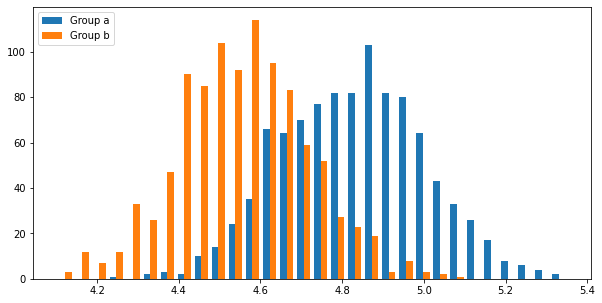

In [ ]:
bs_a = bs.bootstrap(series_1.values, stat_func=bs_stats.mean, 
             num_iterations=1000, iteration_batch_size=20, 
             return_distribution=True)

bs_b = bs.bootstrap(series_2.values, stat_func=bs_stats.mean, 
             num_iterations=1000, iteration_batch_size=20, 
             return_distribution=True)

plt.figure(figsize=(10,5))
plt.hist([bs_a, bs_b], bins = 30, label=['Group a', 'Group b'])
plt.legend(loc='upper left')
plt.show()

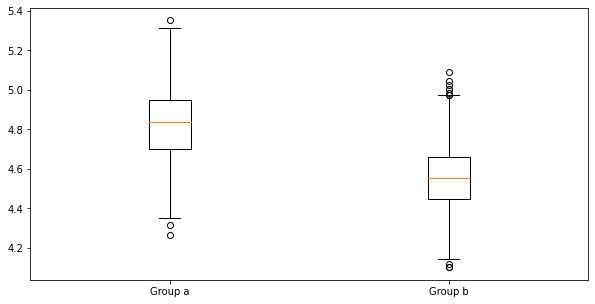

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot([bs_a, bs_b])
labels=['Group a', 'Group b']
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()

Проверим распределения на нормальность с помощью критерия Шапиро.

In [ ]:
alpha = 0.05
st = shapiro(pd.Series(bs_a))
print('Distribution A is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))
st = shapiro(pd.Series(bs_b))
print('Distribution B is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distribution A is normal

Distribution B is normal



Распределения нормальны! Наконец-то. Для проверки равенства дисперсий восолпьзуемся F-критерием Фишера: параметрический, основан на предположении о равенстве выборок нормальному закону.

In [ ]:
alpha = 0.05
p_value = f_oneway(bs_a, bs_b)[1]
print('{} the H0: Var(X1) == Var(X2)\n'.format({True:'Reject', False:'Confirm'}[p_value > alpha]))

Confirm the H0: Var(X1) == Var(X2)



Выборки имеют вид нормального распределения и равенство дисперсий. Для оценки статистической значимости различий воспользуемся t-критерием Стьюдента.

In [ ]:
from scipy.stats import ttest_ind

alpha = 0.05
st = ttest_ind(bs_a, bs_b)

print('Diffs is {}significant'.format({True: '', False: 'not'}[st[1] < alpha]))

Diffs is significant


Различия в группах статистически значимы. 

## Проведем исследование количества неуспешных целевых сессий. 

In [ ]:
series_1 = df_byuser.loc[df_byuser.group == 'A']['churn_visits']
series_2 = df_byuser.loc[df_byuser.group == 'B']['churn_visits']

Проверим на нормальность с помощью критерия Шапиро.

In [ ]:
alpha = 0.05
st = shapiro(pd.Series(series_1))
print('Distribution A is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))
st = shapiro(pd.Series(series_2))
print('Distribution B is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distribution A is not normal

Distribution B is not normal



Применим библиотеку bootstrapped. 

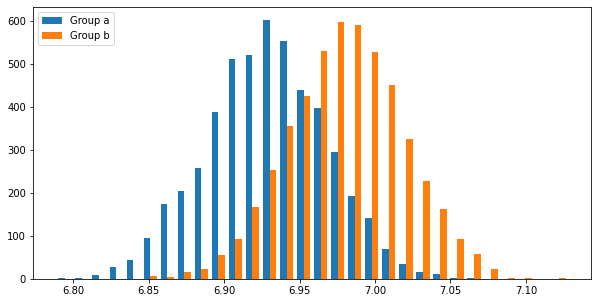

In [ ]:
bs_a = bs.bootstrap(series_1.values, stat_func=bs_stats.mean, 
             num_iterations=5000, iteration_batch_size=300, 
             return_distribution=True)

bs_b = bs.bootstrap(series_2.values, stat_func=bs_stats.mean, 
             num_iterations=5000, iteration_batch_size=300, 
             return_distribution=True)

plt.figure(figsize=(10,5))
plt.hist([bs_a, bs_b], bins = 30, label=['Group a', 'Group b'])
plt.legend(loc='upper left')
plt.show()

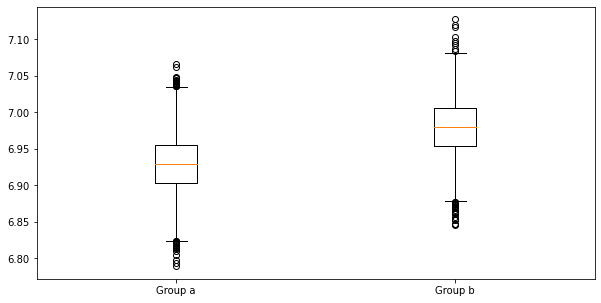

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot([bs_a, bs_b])
labels=['Group a', 'Group b']
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()

Проверим новые выборки на нормальность с помощью критерия Шапиро. 

In [ ]:
alpha = 0.05
st = shapiro(pd.Series(bs_a))
print('Distribution A is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))
st = shapiro(pd.Series(bs_b))
print('Distribution B is {}normal\n'.format( {True:'not ',False:''}[st[1] < alpha]))

Distribution A is normal

Distribution B is normal



Оценим дисперсии с помощью критерия Фишера. 

In [ ]:
alpha = 0.05
p_value = f_oneway(bs_a, bs_b)[1]
print('{} the H0: Var(X1) == Var(X2)\n'.format({True:'Reject', False:'Confirm'}[p_value > alpha]))

Confirm the H0: Var(X1) == Var(X2)



Применим t-тест Стьюдента на различие статистически значимых отличий в метриках.

In [ ]:
alpha = 0.05
st = ttest_ind(bs_a, bs_b)

print('Diffs is {}significant'.format({True: '', False: 'not'}[st[1] < alpha]))

Diffs is significant


Различия в группах статистически значимы. 